# Iterative Inpaint

## Install & import libraries

In [ ]:
# Run this line in Colab to install the package if it is
# not already installed.
!pip install git+https://github.com/openai/glide-text2im

  Cloning https://github.com/openai/glide-text2im to /tmp/pip-req-build-0e8axho6
  Running command git clone --filter=blob:none --quiet https://github.com/openai/glide-text2im /tmp/pip-req-build-0e8axho6
  Resolved https://github.com/openai/glide-text2im to commit 69b530740eb6cef69442d6180579ef5ba9ef063e
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 1.9 MB/s eta 0:00:00
  Created wheel for glide-text2im: filename=glide_text2im-0.0.0-py3-none-any.whl size=1953625 sha256=2e2d89d21ff18decf1e7045a8b0a2941016f3e42126c2d3b8721a8cc9e0be6c6
  Stored in directory: /tmp/pip-ephem-wheel-cache-t2zo2b0q/wheels/88/21/5e/57cab1c1078317022fe11d86e1596fdaa12260531220ac0c99
Successfully built glide-text2im


In [ ]:
import os

import random
from IPython.display import display
from pathlib import Path
from typing import Tuple, Dict, List, Any
from PIL import Image
import numpy as np
import torch as th
import torch.nn.functional as F
import torchvision.utils as vutils
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor, Compose, Normalize
from torchvision.utils import save_image
from glide_text2im.download import load_checkpoint
from glide_text2im.model_creation import (
    create_model_and_diffusion,
    model_and_diffusion_defaults,
    model_and_diffusion_defaults_upsampler
)

## Configuration

In [ ]:
###############################
# Dataset pipeline parameters #
###############################
num_workers = 2
ngpu = 1

###############################
#      Model parameters       #
###############################

# Sampling parameters
prompt = "an image of measles on dark skin"
batch_size = 1
guidance_scale = 5.0

# Tune this parameter to control the sharpness of 256x256 images.
# A value of 1.0 is sharper, but sometimes results in grainy artifacts.
upsample_temp = 0.997

## GDrive connection

In [ ]:
GDRIVE = True
# accessing GDrive preprocessed dataset folder
if GDRIVE:
    from google.colab import drive
    drive.mount('/content/gdrive/', force_remount=True)

# accessing dataset folder and printing files contained in it
os.chdir('./gdrive/MyDrive/AII Project/experiments-synthetic-generation-clinical-skin-images-main')
!ls

Mounted at /content/gdrive/
 crops		     generated_images	     lightning_logs   outputs-gan       VAE_128
 dataset	     generate_images.ipynb   logs	      saved_models      VAE_128_GANloss
'Dataset Analysis'   GLIDE_256.ipynb	     low_contrast     test_images       wandb
 Evaluation	     glide_model_cache	     Old	      Test_sock_burn3


## Dataset import

In [ ]:
class TanhRescaler(object):
    def __call__(self, input_data):
        # Assuming input_data is a PyTorch tensor
        transformed_data = input_data * 2 - 1
        return transformed_data

class MaskPairDataset(Dataset):
    '''
    Custom PyTorch dataset class for handling paired image-mask data.

    Args:
        base_folder (Path): The base folder containing the image and mask pairs.
        transforms (callable, optional): Transforms to be applied to the input images. Default is None.
        mask_transforms (callable, optional): Transforms to be applied to the masks. Default is None.
        suffix (str, optional): The suffix added to image filenames to obtain corresponding mask filenames. Default is "_mask".
        is_mask_rgb (bool, optional): Flag indicating whether the masks are in RGB format. Default is False.
        mask (bool, optional): Flag indicating whether the dataset includes masks. Default is False.

    Attributes:
        transforms (callable): Transforms to be applied to the input images.
        mask_transforms (callable): Transforms to be applied to the masks.
        is_mask_rgb (bool): Flag indicating whether the masks are in RGB format.
        mask (bool): Flag indicating whether the dataset includes masks.
        img_list (list): List of image file paths.
        paired_data (list): List of paired image and mask file paths.

    Methods:
        __len__(self) -> int:
            Returns the total number of paired image-mask data in the dataset.

        __getitem__(self, index) -> Dict:
            Retrieves an item (image and its corresponding mask) by index.
    '''

    def __init__(self, base_folder : Path,
                 transforms = None,
                 mask_transforms = None,
                 suffix:str = "_mask",
                 is_mask_rgb:bool = False,
                 mask=False):

        self.transforms = transforms
        self.mask_transforms = mask_transforms
        self.is_mask_rgb = is_mask_rgb
        self.mask = mask
        self.img_list = []

        # Get all png images in the folder
        self.img_list = base_folder.glob("*.png")
        # Remove the masks
        self.img_list = [img for img in self.img_list if "mask" not in img.name]

        # Create the pairs
        self.paired_data = []

        if self.mask:
          for img in self.img_list:
              supposed_mask = base_folder / (img.stem + suffix + ".png")
              if supposed_mask.is_file():
                  self.paired_data.append((img, supposed_mask))

    def __len__(self) -> int:
        '''
        Returns the total number of paired image-mask data in the dataset.

        Returns:
            int: Length of paired data.
        '''
        if self.mask:
          return len(self.paired_data)
        else:
          return len(self.img_list)


    def __getitem__(self, index) -> Dict:
        '''
        Retrieves an item (image and its corresponding mask) by index.

        Args:
            index (int): Index of the item to retrieve.

        Returns:
            Dict: A dictionary containing 'img' (image) and 'mask' (corresponding mask).
        '''

        if self.mask:
            img_path, mask_path = self.paired_data[index]
            img = Image.open(img_path).convert("RGB")
            if self.is_mask_rgb:
                mask = Image.open(mask_path).convert("RGB")
            else:
                mask = Image.open(mask_path).convert("L")
        else:
            img_path = self.img_list[index]
            img = Image.open(img_path).convert("RGB")

        # Apply transforms
        if self.transforms:
            # Make sure that random transforms to both image and mask behave in the same way
            seed = np.random.randint(2147483647)

            random.seed(seed)
            th.manual_seed(seed)
            img = self.transforms(img)

            random.seed(seed)
            th.manual_seed(seed)

        if self.mask_transforms and self.mask:
                mask = self.transforms(mask)

        if self.mask:
            return {"img":img, "mask":mask}
        else:
            return {"img":img}

In [ ]:
# Building the dataset and dataloader (just rerun in case of errors for input/output)

base_folder = Path("./crops")

transforms_ = transforms.Compose([ToTensor(), TanhRescaler()])

dataset = MaskPairDataset(base_folder, transforms=transforms_, suffix="_mask2", is_mask_rgb=True)#, img_norm=Normalize(mean=means, std=stds), mask_norm=Normalize(mean=[0.5], std=[0.5]))

print('This dataset contains {} samples, with dimension {}'.format(len(dataset),dataset[0]['img']))


This dataset contains 11994 samples, with dimension tensor([[[-0.1137, -0.1137, -0.1059,  ..., -0.0431, -0.0588, -0.0588],
         [-0.0980, -0.0980, -0.0902,  ..., -0.0275, -0.0353, -0.0510],
         [-0.0745, -0.1059, -0.1137,  ..., -0.0431, -0.0431, -0.0667],
         ...,
         [ 0.0980,  0.1216,  0.1059,  ...,  0.0980,  0.0980,  0.1137],
         [ 0.0902,  0.1059,  0.0980,  ...,  0.0902,  0.0902,  0.1059],
         [ 0.0745,  0.0824,  0.0745,  ...,  0.0902,  0.0824,  0.1059]],

        [[-0.3255, -0.3255, -0.3333,  ..., -0.2314, -0.2471, -0.2471],
         [-0.3176, -0.3176, -0.3176,  ..., -0.2157, -0.2471, -0.2627],
         [-0.2941, -0.3255, -0.3412,  ..., -0.2314, -0.2314, -0.2549],
         ...,
         [-0.0745, -0.0510, -0.0667,  ..., -0.1059, -0.1059, -0.0902],
         [-0.0824, -0.0667, -0.0824,  ..., -0.1137, -0.1137, -0.0980],
         [-0.1059, -0.0980, -0.1059,  ..., -0.1137, -0.0980, -0.0980]],

        [[-0.4588, -0.4588, -0.4431,  ..., -0.3255, -0.3412, -0.

In [ ]:
# This notebook supports both CPU and GPU.
# On CPU, generating one sample may take on the order of 20 minutes.
# On a GPU, it should be under a minute.

# Decide which device we want to run on
device = th.device("cuda:0" if (th.cuda.is_available() and ngpu > 0) else "cpu")


# Create the dataloader
dataloader = th.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         pin_memory = th.cuda.is_available(),
                                         shuffle=True, num_workers=num_workers)

## Import Glide model

##GLIDE: Towards Photorealistic Image Generation and Editing with Text-Guided Diffusion Models
 delves into the application of diffusion models to generate lifelike images contingent on textual descriptions. The study evaluates two distinct guidance techniques: firstly, the CLIP guidance method employs a pre-trained image and text embedding model (CLIP) to direct the diffusion process, steering it towards generating images that align with the provided textual descriptions. Secondly, the classifier-free guidance approach involves a direct interpolation between predictions from the diffusion model with and without text labels. This technique enhances flexibility and eliminates the necessity for a separate classifier, offering an alternative and potentially more versatile strategy for text-guided image generation.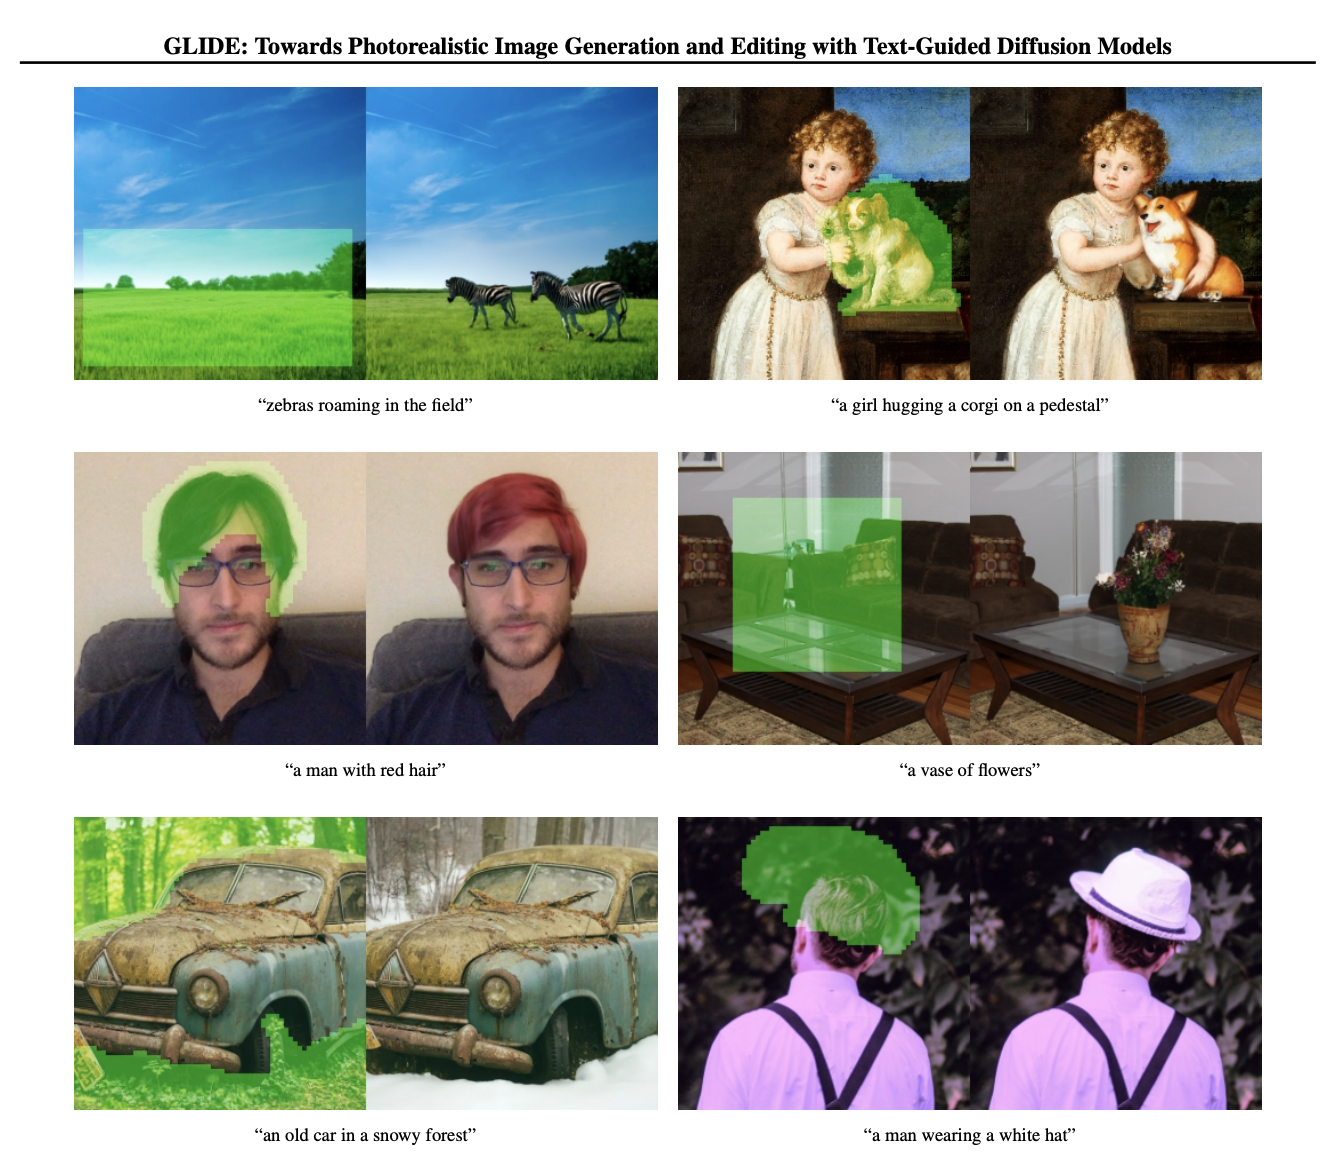

In [ ]:
# Create base model.
options = model_and_diffusion_defaults()
options['inpaint'] = True
options['use_fp16'] = has_cuda
options['timestep_respacing'] = '100' # use 100 diffusion steps for fast sampling
model, diffusion = create_model_and_diffusion(**options)
model.eval()
if has_cuda:
    model.convert_to_fp16()
model.to(device)
model.load_state_dict(load_checkpoint('base-inpaint', device))
print('total base parameters', sum(x.numel() for x in model.parameters()))

total base parameters 385037638


In diffusion networks, an "upsampler" is a component used to increase the spatial resolution of input data. Particularly in diffusion models for image generation, an upsampler helps enhance details and generate higher-resolution images by gradually increasing the size of the data during the diffusion process. The specific role and design of the upsampler may vary based on the objectives and architecture of the diffusion model in use.

In [ ]:
# Create upsampler model.
options_up = model_and_diffusion_defaults_upsampler()
options_up['inpaint'] = True
options_up['use_fp16'] = has_cuda
options_up['timestep_respacing'] = 'fast27' # use 27 diffusion steps for very fast sampling
model_up, diffusion_up = create_model_and_diffusion(**options_up)
model_up.eval()
if has_cuda:
    model_up.convert_to_fp16()
model_up.to(device)
model_up.load_state_dict(load_checkpoint('upsample-inpaint', device))
print('total upsampler parameters', sum(x.numel() for x in model_up.parameters()))

total upsampler parameters 398368198


## Images utils

In [ ]:
def show_images(batch: th.Tensor):
    """ Display a batch of images inline. """
    scaled = ((batch + 1)*127.5).round().clamp(0,255).to(th.uint8).cpu()
    reshaped = scaled.permute(2, 0, 3, 1).reshape([batch.shape[2], -1, 3])
    display(Image.fromarray(reshaped.numpy()))

def save_images(batch: th.Tensor, path):
    """ Display a batch of images inline. """
    scaled = ((batch + 1)*127.5).round().clamp(0,255).to(th.uint8).cpu()
    reshaped = scaled.permute(2, 0, 3, 1).reshape([batch.shape[2], -1, 3])
    image = Image.fromarray(reshaped.numpy())
    image.save(path)

def read_image(path: str, size: int = 256) -> Tuple[th.Tensor, th.Tensor]:
    pil_img = Image.open(path).convert('RGB')
    pil_img = pil_img.resize((size, size), resample=Image.BICUBIC)
    img = np.array(pil_img)
    return th.from_numpy(img)[None].permute(0, 3, 1, 2).float() / 127.5 - 1

## Model facade

This code defines a function named `fill_mask` that samples from a base model using a diffusion process. It encodes a prompt, creates tokens, and prepares a model conditioning dictionary. The function uses a classifier-free guidance sampling approach, adjusting predictions based on known parts of the image. The sampled images are returned after applying denoising to ensure accurate predictions for known regions. The process involves creating an extended batch size, generating model outputs, and returning a subset of the samples.![guassian_splat2.png](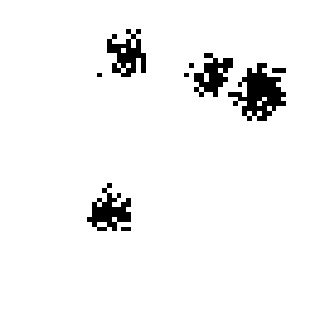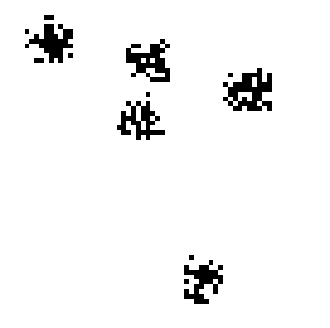)

In [ ]:
##############################
# Sample from the base model #
##############################


def fill_mask():
    # Create the text tokens to feed to the model.
    tokens = model.tokenizer.encode(prompt)
    tokens, mask = model.tokenizer.padded_tokens_and_mask(
        tokens, options['text_ctx']
    )

    # Create the classifier-free guidance tokens (empty)
    full_batch_size = batch_size * 2
    uncond_tokens, uncond_mask = model.tokenizer.padded_tokens_and_mask(
        [], options['text_ctx']
    )

    # Pack the tokens together into model kwargs.
    model_kwargs = dict(
        tokens=th.tensor(
            [tokens] * batch_size + [uncond_tokens] * batch_size, device=device
        ),
        mask=th.tensor(
            [mask] * batch_size + [uncond_mask] * batch_size,
            dtype=th.bool,
            device=device,
        ),

        # Masked inpainting image
        inpaint_image=(source_image_64 * source_mask_64).repeat(full_batch_size, 1, 1, 1).to(device),
        inpaint_mask=source_mask_64.repeat(full_batch_size, 1, 1, 1).to(device),
    )

    # Create an classifier-free guidance sampling function
    def model_fn(x_t, ts, **kwargs):
        half = x_t[: len(x_t) // 2]
        combined = th.cat([half, half], dim=0)
        model_out = model(combined, ts, **kwargs)
        eps, rest = model_out[:, :3], model_out[:, 3:]
        cond_eps, uncond_eps = th.split(eps, len(eps) // 2, dim=0)
        half_eps = uncond_eps + guidance_scale * (cond_eps - uncond_eps)
        eps = th.cat([half_eps, half_eps], dim=0)
        return th.cat([eps, rest], dim=1)

    def denoised_fn(x_start):
        # Force the model to have the exact right x_start predictions
        # for the part of the image which is known.
        return (
            x_start * (1 - model_kwargs['inpaint_mask'])
            + model_kwargs['inpaint_image'] * model_kwargs['inpaint_mask']
        )

    # Sample from the base model.
    model.del_cache()
    samples = diffusion.p_sample_loop(
        model_fn,
        (full_batch_size, 3, options["image_size"], options["image_size"]),
        device=device,
        clip_denoised=True,
        progress=True,
        model_kwargs=model_kwargs,
        cond_fn=None,
        denoised_fn=denoised_fn,
    )[:batch_size]
    model.del_cache()

    return samples

This code defines an upsampling function named `upsample`. It takes a prompt, encodes it using a tokenizer, and creates a model conditioning dictionary. The function utilizes a denoising process to upsample low-resolution images based on the given text tokens. It uses a pre-trained model (`model_up`) and performs upsampling using a diffusion process, producing high-resolution samples. The resulting upsampled images are returned by the function.

In [ ]:
##############################
# Upsample the 64x64 samples #
##############################


def upsample():
    tokens = model_up.tokenizer.encode(prompt)
    tokens, mask = model_up.tokenizer.padded_tokens_and_mask(
        tokens, options_up['text_ctx']
    )

    # Create the model conditioning dict.
    model_kwargs = dict(
        # Low-res image to upsample.
        low_res=((samples+1)*127.5).round()/127.5 - 1,

        # Text tokens
        tokens=th.tensor(
            [tokens] * batch_size, device=device
        ),
        mask=th.tensor(
            [mask] * batch_size,
            dtype=th.bool,
            device=device,
        ),

        # Masked inpainting image.
        inpaint_image=(source_image_256 * source_mask_256).repeat(batch_size, 1, 1, 1).to(device),
        inpaint_mask=source_mask_256.repeat(batch_size, 1, 1, 1).to(device),
    )

    def denoised_fn(x_start):
        # Force the model to have the exact right x_start predictions
        # for the part of the image which is known.
        return (
            x_start * (1 - model_kwargs['inpaint_mask'])
            + model_kwargs['inpaint_image'] * model_kwargs['inpaint_mask']
        )

    # Sample from the base model.
    model_up.del_cache()
    up_shape = (batch_size, 3, options_up["image_size"], options_up["image_size"])
    up_samples = diffusion_up.p_sample_loop(
        model_up,
        up_shape,
        noise=th.randn(up_shape, device=device) * upsample_temp,
        device=device,
        clip_denoised=True,
        progress=True,
        model_kwargs=model_kwargs,
        cond_fn=None,
        denoised_fn=denoised_fn,
    )[:batch_size]
    model_up.del_cache()

    return  up_samples



## Apply the Random Masks (boxes)

This is one of the most important aspects of the algorithm, the number of box and size makes all the difference. Some notes.



*   Inpainting uses the rest of images and conditional prior, therefore making the box too big would can lose context.
*   Making the box too small cause practically no meaningful change but rather blurring.
*   The number of steps should also be finetuned to not cause boxes from overlapping so often. This can create a sort of xerox affect only causing more bluring.
*   Dynamically chaning the box size and sample position to avoid overlapping would should improve results.









In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def generate_image_with_boxes(n, num_boxes, box_size):
    # Create an empty array filled with ones (white pixels)
    image = np.ones((1, n, n))

    # Generate random positions for black boxes within the image
    for _ in range(num_boxes):
        top_left_x = np.random.randint(0, n - box_size)
        top_left_y = np.random.randint(0, n - box_size)

        # Assign zeros (black pixels) to the specific area of the black box
        image[:, top_left_y:top_left_y + box_size, top_left_x:top_left_x + box_size] = 0

    return image

# Example usage
def square_mask():
    image_size = 64  # Adjust this to change the image size
    num_of_boxes = 1  # Adjust this to change the number of black boxes
    box_size = 15 # Adjust this to change the size of each black box

    random_mask = generate_image_with_boxes(image_size, num_of_boxes, box_size)

    # Display the generated image at 64x64 size with an aspect ratio of 1:1
    #plt.figure(figsize=(1, 1))  # Set figure size to control display size
    #plt.imshow(random_mask[0], cmap='gray', aspect='auto')  # Displaying the first channel of the image
    #plt.axis('off')  # Turn off axis labels
    #plt.show()

    random_mask_tensor = th.from_numpy(random_mask).unsqueeze(0).to(th.float32)

    return random_mask_tensor


def apply_mask_square(image_name,random_mask_tensor):
    # Source image we are inpainting
    source_image_256 = read_image(image_name, size=256)
    source_image_64 = read_image(image_name, size=64)

    # The mask should always be a boolean 64x64 mask, and then we
    # can upsample it for the second stage.
    source_mask_64 = th.ones_like(source_image_64)[:, :1]
    source_mask_64[:, :, 35:] = 0
    source_mask_64 = random_mask_tensor
    source_mask_256 = F.interpolate(random_mask_tensor, (256, 256), mode='nearest')

    # Visualize the image we are inpainting
    #print(type(source_mask_64[0]))

    return {
          'source_mask_64': source_mask_64,
          'source_image_64': source_image_64,
          'source_image_256': source_image_256,
          'source_mask_256': source_mask_256,
          'masked_source_image_256': source_image_256 * source_mask_256
      }


def apply_mask_square_fromTensor(image,random_mask_tensor):
    #image: tensor of dimension [batch,256,256]

    # Source image we are inpainting
    source_image_256 = image.clone()
    # 64x64 version of original 256x256 image
    image_resize = image.clone()
    resized_image = F.interpolate(image_resize, size=(64, 64))
    source_image_64 = resized_image

    # The mask should always be a boolean 64x64 mask, and then we
    # can upsample it for the second stage.
    source_mask_64 = th.ones_like(source_image_64)[:, :1]
    source_mask_64[:, :, 35:] = 0
    source_mask_64 = random_mask_tensor
    source_mask_256 = F.interpolate(random_mask_tensor, (256, 256), mode='nearest')

    # Visualize the image we are inpainting
    #print(type(source_mask_64[0]))

    return {
          'source_mask_64': source_mask_64,
          'source_image_64': source_image_64,
          'source_image_256': source_image_256,
          'source_mask_256': source_mask_256,
          'masked_source_image_256': source_image_256 * source_mask_256
      }

# Inpainting with Diffusion

This is the part of the code that runs the iterative inpaint algorithm. Here is some of the terminology.



*   Runs take an orginal source image and create x many different outputs.
*   Steps are the amount of times we mask and inpaint an image iteratively.
*   The 100 diffusion steps happens in one Step of this algorithm
*   Then its uses fast27 which is the fastest upsampling algorithm





0


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

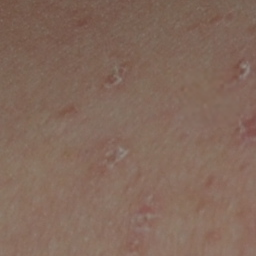

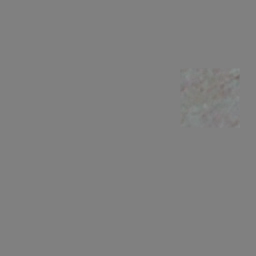

1


  0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
output_gifs = False
pic_name = 'fake_misleases'
main_folder = "glide_generated_images/"
#first = up_samples.cpu()
steps = 12
runs = 5
save_original_img = True

# cycle over all images in dataset
for i, data in enumerate(dataloader, 0):

    folder = main_folder + f"sample_{i}"
    os.makedirs(folder, exist_ok=True)

    # different diffusion rounds for a same image
    for x in range(0,runs):

        curr_run = f'run{x:03d}'

        try:
          os.makedirs(folder+ '/' + curr_run, exist_ok=True)
        except:
          pass

        # resave first base image
        if save_original_img:
          save_images(data['img'].cpu(), folder + "/" + curr_run+ "/" + 'true_misleases.png')

        # diffusion steps
        for y in range(0,steps):

            if y == 0:
              random_mask_tensor_square = square_mask()
              result = apply_mask_square_fromTensor(data['img'], random_mask_tensor_square) #apply_mask_square(folder  + pic_name+'.png',random_mask_tensor_square )
              source_image_256 = result['source_image_256']
              first = source_image_256.cpu()
              save_images(first, folder + "/" + curr_run+ "/" +  pic_name+f'{y:03d}.png')

            else:
              random_mask_tensor_square = square_mask()
              result = apply_mask_square(folder + "/" + curr_run+ "/" + pic_name+f'{y:03d}.png',random_mask_tensor_square )

            # Accessing individual items from the result dictionary
            source_mask_64 = result['source_mask_64']
            source_image_64 = result['source_image_64']
            source_image_256 = result['source_image_256']
            source_mask_256 = result['source_mask_256']
            masked_source_image_256 = result['masked_source_image_256']

            print(y)

            samples = fill_mask()

            up_samples = upsample()

            # Show the output
            #show_images(source_image_256)
            show_images(up_samples)
            save_images(up_samples.cpu(), folder + "/" + curr_run+ "/" +  pic_name+f'{y+1:03d}.png')
            show_images(up_samples.cpu()-first)

    images = []

    if output_gifs:

        # Load images into the list
        for j in range(0,steps):  # Assuming you have 50 images: amin0.png to amin49.png
            filename = folder + pic_name+f'{j}.png'
            img = Image.open(filename)
            images.append(img)


        # Save the list of images as a GIF
        images[0].save(folder+ f'generated_images_sample_{i}.gif',
                      save_all=True,
                      append_images=images[1:],
                      optimize=False,
                      duration=125,  # Set the duration between frames (in milliseconds)
                      loop=0)

# Future Works and Miscellaneous

We tried changing the masks from normal squares to discrete guassians, this is because inpaint masks have to binary. The idea was might help change lead to smoother transition. However not much changed, the masks are 258x258 in resoltion and when shrank down to 64x64, they practically form squares.

![Getting Started](./guassian_mask.png)
![Getting Started](./guassian_splat2.png)

Some important factors to think about:
* Total area covered that eventually gets masked, is it necessary to mask 100% of the image.
* How often is the same pixel masked repeatedly, too often leads to bluring.
* Run time is an important factor at this stage the algoritm is too slow.
* The size and number of boxes are the two bigget parameters
* All global details remain the same, such as content, lighing, seasons, hard borders (horizons). Dont expect these to change.

# Results with other images

Castle on Mountain

![Getting Started](./gens.png)

Sockburn

![Getting Started](./Gens1.png)

![Getting Started](./Gens2.png)

![Getting Started](./Gens_sand.png)

![Getting Started](./Gens_mountain.png)